In [2]:
import pandas as pd
from datetime import datetime

# Load and parse the dataset
file_path = 'ERA5_malmo/era5_malmo_2024_combined.csv'
df = pd.read_csv(file_path, parse_dates=['time'])



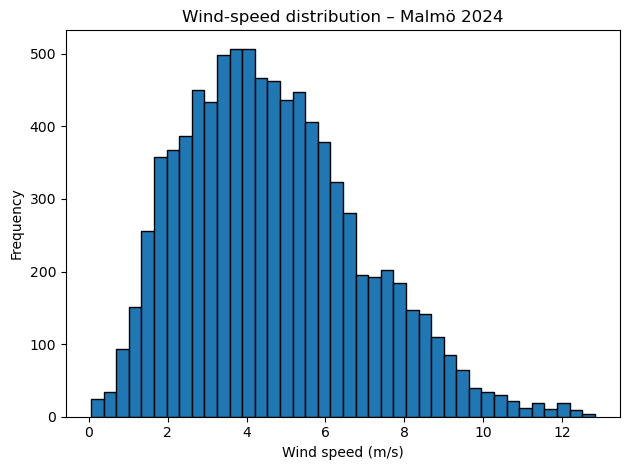

In [8]:
import matplotlib.pyplot as plt

# Histogram of wind speed
plt.figure()
df['wind_speed'].plot(kind='hist', bins=40, edgecolor='black')
plt.title("Wind‑speed distribution – Malmö 2024")
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Frequency")
plt.tight_layout()


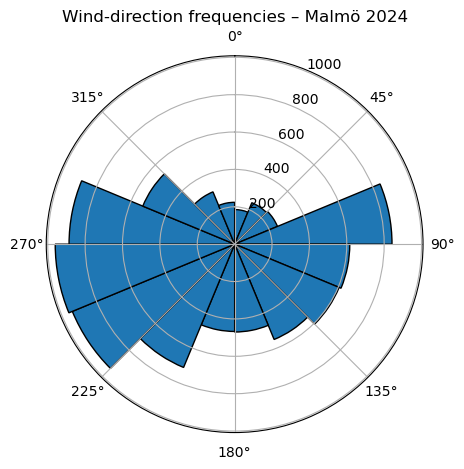

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Wind rose (direction frequencies)
direction = df['wind_direction'].dropna().values
# Convert degrees to radians
theta = np.deg2rad(direction)

# Define bins (16 sectors: 22.5° each)
num_sectors = 16
bins = np.linspace(0, 2*np.pi, num_sectors + 1)
sector_counts, _ = np.histogram(theta, bins=bins)

# Plot
plt.figure()
ax = plt.subplot(111, projection='polar')
width = 2 * np.pi / num_sectors
bars = ax.bar(bins[:-1], sector_counts, width=width, align='edge', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.title("Wind‑direction frequencies – Malmö 2024")
plt.tight_layout()


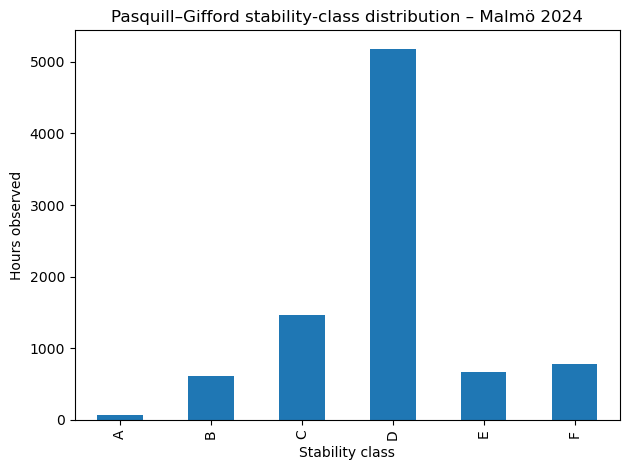

In [10]:
# Stability class distribution
plt.figure()
df['stability_class'].value_counts().sort_index().plot(kind='bar')
plt.title("Pasquill–Gifford stability‑class distribution – Malmö 2024")
plt.xlabel("Stability class")
plt.ylabel("Hours observed")
plt.tight_layout()


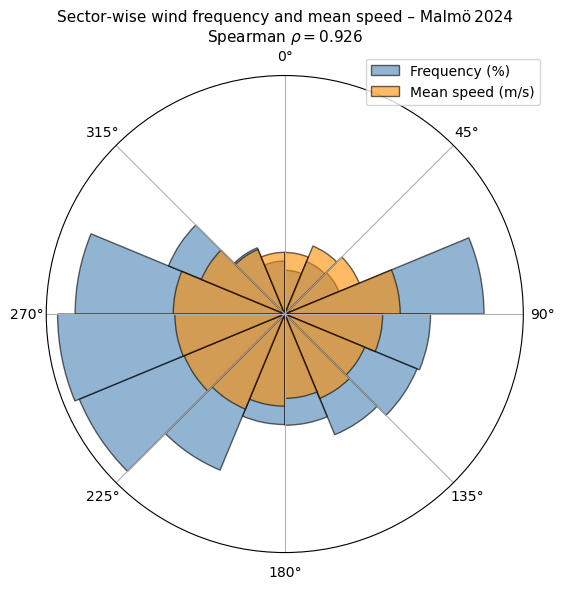

In [20]:
# --- Cell 1: regenerate plot with Spearman correlation -----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# ------------------------------------------------------------------
# 2. Bin wind directions into 16 equal sectors (22.5° each)
num_sectors = 16
edges = np.linspace(0, 360, num_sectors + 1)           # 0, 22.5, 45, ..., 360
labels_deg = 0.5 * (edges[:-1] + edges[1:])            # mid‑angles for labels

sector_idx = np.digitize(df['wind_direction'] % 360, edges, right=False) - 1
sector_idx[sector_idx == num_sectors] = 0               # map 360° to sector 0
df['sector'] = sector_idx

# ------------------------------------------------------------------
# 3. Aggregate statistics
freq_counts = df.groupby('sector')['wind_speed'].size()        # raw counts
freq_pct    = 100 * freq_counts / freq_counts.sum()            # convert to %
mean_speed  = df.groupby('sector')['wind_speed'].mean()        # m/s

# ------------------------------------------------------------------
# 4. Correlation measures
pear_r, pear_p = pearsonr(freq_pct, mean_speed)
spear_rho, spear_p = spearmanr(freq_pct, mean_speed)

# ------------------------------------------------------------------
# 5. Polar bar plot
theta = np.deg2rad(labels_deg)
width = 2 * np.pi / num_sectors

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(7,6))

# Frequency bars
ax.bar(theta, freq_pct, width=width, color='steelblue', alpha=0.6,
       edgecolor='k', label='Frequency (%)')

# Mean‑speed bars (overlay)
ax.bar(theta, mean_speed, width=width, color='darkorange', alpha=0.6,
       edgecolor='k', label='Mean speed (m/s)')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

title = ("Sector‑wise wind frequency and mean speed – Malmö 2024\n"
         f"Spearman $\\rho={spear_rho:.3f}$")
ax.set_title(title, pad=25, fontsize=11)

ax.set_rticks([])  # hide radial ticks for cleaner plot
ax.legend(loc='upper right', bbox_to_anchor=(1.05, 1.05), frameon=True)

plt.tight_layout()

In [1]:
def generate_mc_leak_rates(
    tau=1081.1,
    t0=210,
    duration=3600,
    dt=10,
    n_samples=1000,
    *,
    A0_hat=0.001347103726986978,  # user estimate for triangular mode
    renormalize=False,
    eps=1e-12,
):
    """
    Monte Carlo leak-rate profiles: plateau A0 then exponential decay.

    A0 ~ Triangular(low=A0_hat/2, mode=A0_hat, high=1/t0).
    (The high endpoint is slightly shrunk by eps to avoid roundoff
     that could make A1 negative.)

    Parameters
    ----------
    tau : float
        Decay time constant (s).
    t0 : float
        Plateau duration (s).
    duration : int
        Total profile duration (s).
    dt : int
        Time step (s).
    n_samples : int
        Number of MC samples.
    A0_hat : float
        Mode of triangular distribution.
    random_seed : int or None
        RNG seed.
    renormalize : bool
        If True, scale each discrete profile so ∑ rate*dt = 1.
    eps : float
        Fractional shrink for the high endpoint to keep A1 ≥ 0 numerically.

    Returns
    -------
    rates : ndarray, shape (n_samples, n_steps)
        Leak‑rate profiles (fraction per second).
        (Callers expecting only rates continue to work.)
    """

    # time grid (inclusive of duration)
    t = np.arange(0, duration + dt, dt)
    n_steps = t.size

    # triangular params
    low  = 0.5 * A0_hat
    mode = A0_hat
    high = (1.0 / t0) * (1.0 - eps)  # slight shrink for numeric safety

    # ensure ordering (in case user passes unusual A0_hat)
    if not (low < mode < high):
        raise ValueError(f"Triangular params invalid: low={low}, mode={mode}, high={high}.")

    # sample plateau rates
    A0_samples = np.random.default_rng().triangular(low, mode, high, size=n_samples)

    # decay amplitude (continuous mass balance assumption)
    A1_samples = (1.0 - A0_samples * t0) / tau
    A1_samples = np.clip(A1_samples, 0.0, None)  # numeric guard

    # build profiles
    t_mat  = t[None, :]              # (1, n_steps)
    A0_mat = A0_samples[:, None]     # (n_samples, 1)
    A1_mat = A1_samples[:, None]     # (n_samples, 1)

    plateau_mask = (t_mat <= t0)     # (1, n_steps)
    rates = np.empty((n_samples, n_steps), dtype=float)

    # plateau region
    rates[:, plateau_mask[0]] = A0_mat

    # decay region
    decay_times = t_mat - t0         # ≤0 before t0, >0 after
    post_mask = ~plateau_mask[0]
    rates[:, post_mask] = A1_mat * np.exp(-decay_times[:, post_mask] / tau)

    # discrete renormalization (accounts for truncation at duration)
    if renormalize:
        mass = rates.sum(axis=1) * dt
        mass = np.where(mass > 0, mass, 1.0)
        rates /= mass[:, None]

    return rates

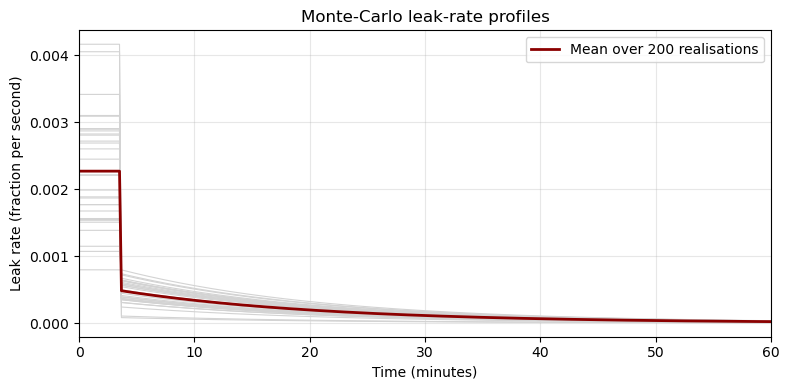

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Parameters consistent with your generate_mc_leak_rates definition
n_samples = 200
tau   = 1081.1     # s
t0    = 210        # s
dt    = 10         # s
dur   = 3600       # s
renorm = True

# ------------------------------------------------------------------
# Call the pre‑defined function (assumed already imported in the notebook)
rates = generate_mc_leak_rates(
    tau=tau, t0=t0, duration=dur, dt=dt,
    n_samples=n_samples, renormalize=renorm
)

# Time vector (since the function returns only `rates`)
t = np.arange(0, dur + dt, dt)          # seconds
t_minutes = t / 60.0                    # convert for nicer x‑axis labels

# ------------------------------------------------------------------
# Visualisation
fig, ax = plt.subplots(figsize=(8, 4))

# Plot a subset of individual realisations in light grey
subset = 30
for i in range(min(subset, n_samples)):
    ax.plot(t_minutes, rates[i], color='lightgrey', linewidth=0.8)

# Plot the mean profile in bold red
mean_profile = rates.mean(axis=0)
ax.plot(t_minutes, mean_profile, color='darkred', linewidth=2,
        label=f'Mean over {n_samples} realisations')

# Formatting
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Leak rate (fraction per second)")
ax.set_title("Monte‑Carlo leak‑rate profiles")
ax.legend()
ax.set_xlim(0, dur / 60)
ax.grid(alpha=0.3)

plt.tight_layout()


In [7]:
import pandas as pd
import numpy as np
from datetime import time as dtime

# ------------ 0. Load data -------------
df = pd.read_csv("ERA5_malmo/era5_malmo_2024_combined.csv", parse_dates=["time"])

# ------------ 1. 12 wind-direction sectors -------------
sector_centers = np.arange(0, 360, 30)
ranges = []
for c in sector_centers:
    start = (c - 14) % 360
    end   = (c + 15) % 360
    ranges.append((c, start, end))

def direction_to_sector(d):
    # Treat calm (dir==0 & speed==0) separately if you wish. Here we still bin it.
    for center, start, end in ranges:
        if start <= end:
            if start <= d <= end:
                return center
        else:  # wrap (346–360, 0–15)
            if d >= start or d <= end:
                return center
    return np.nan

df["sector"] = df["wind_direction"].apply(direction_to_sector)

# proportions of each sector
dir_prop = df["sector"].value_counts(normalize=True).sort_index()
dir_prop = dir_prop.dropna()

# ------------ 2. Speed classes + weather type codes -------------
bins   = [-np.inf, 3, 7, np.inf]
labels = ["≤3 m/s (låg)", "3–7 m/s (medel)", ">7 m/s (hög)"]
df["speed_class"] = pd.cut(df["wind_speed"], bins=bins, labels=labels)

DAY_W  = 0.44
NIGHT_W= 0.56

# speed-class distribution from historical data (whole year)
class_prop_tot = df["speed_class"].value_counts(normalize=True).reindex(labels).fillna(0)

# map to Purple Book weather types
weather_codes_day   = {"≤3 m/s (låg)": "2B", "3–7 m/s (medel)": "5C", ">7 m/s (hög)": "8D"}
weather_codes_night = {"≤3 m/s (låg)": "2F", "3–7 m/s (medel)": "5D", ">7 m/s (hög)": "8D"}

weather_rows = []
for cls in labels:
    weather_rows.append({"speed_class": cls, "day_part": "Dag",  "code": weather_codes_day[cls],
                         "stability_letter": weather_codes_day[cls][-1],  # B/C/D
                         "prop": class_prop_tot[cls] * DAY_W})
    weather_rows.append({"speed_class": cls, "day_part": "Natt", "code": weather_codes_night[cls],
                         "stability_letter": weather_codes_night[cls][-1],  # F/D/D
                         "prop": class_prop_tot[cls] * NIGHT_W})

weather_df = pd.DataFrame(weather_rows)
weather_df["prop"] /= weather_df["prop"].sum()   # ensure Σ=1

# ------------ 3. Final matrix (optional to inspect) -------------
mat = pd.DataFrame({
    (r["speed_class"], r["day_part"], r["code"]): dir_prop.values * r["prop"]
    for _, r in weather_df.iterrows()
}, index=dir_prop.index)

# display(mat_pct)  # uncomment in notebook

# --- Build SCENARIOS only (no simulations yet) ---